In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
%matplotlib inline

import zipfile
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [3]:
zf = zipfile.ZipFile('C:/Users/Serueja/Downloads/tabular-playground-series-sep-2022.zip')
test = pd.read_csv(zf.open('test.csv'))
train = pd.read_csv(zf.open('train.csv'))
submission_example = pd.read_csv(zf.open('sample_submission.csv'))

**INITIAL DATA EXPLORATION**

In [4]:
train.head(20)

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267
8,8,2017-01-01,France,KaggleMart,Kaggle Advanced Techniques,610
9,9,2017-01-01,France,KaggleMart,Kaggle Getting Started,463


In [ ]:
train['product'].nunique()

In [ ]:
(train.isna().any(), test.isna().any())

In [ ]:
train.groupby('date')['row_id'].count()

In [ ]:
(train.date.nunique(), test.date.nunique())

In [ ]:
train[train['date'] == '2017-01-01'].head()
train['date'] = pd.to_datetime(train['date'], yearfirst=True)
train['new_date'] = train['date'].dt.to_period('M')

In [ ]:
train.groupby(['country', 'store'])['num_sold'].sum()

**DATA VISUALIZATION**

Here we can see that probably we need to log(x+1) our sales in order to put it through regression models



Also we can notice similarities in our store sales distribution, probably we would need same function to transform the data into normal distribution 

In [ ]:
train[train['store'] == 'KaggleMart']['num_sold'].hist(bins=100)

In [ ]:
train[train['store'] == 'KaggleRama']['num_sold'].hist(bins=100)

In [ ]:
country_sales = train.groupby('country')['num_sold'].sum()

country_sales.sort_values(inplace=True)
sns.barplot(x=country_sales.index, y=country_sales.values)
store_sales = train.groupby('store')['num_sold'].sum()

sns.barplot(x=store_sales.index, y=store_sales.values)

In [ ]:
train.info()

In [ ]:
books_over_time_df = []
k=train[train['product'] == 'Kaggle Advanced Techniques'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle Getting Started'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k) 
k=train[train['product'] == 'Kaggle Recipe Book'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle for Kids: One Smart Goose'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle Advanced Techniques'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)

In [ ]:
#fig, ax = plt.subplots(3, 2, figsize=(5 ,5))
for i in range(len(books_over_time_df)):
    plt.plot_date('new_date', 'num_sold', data = books_over_time_df[i],linestyle='solid')
    plt.xticks(rotation=45)
    plt.xlabel('Месяцы')
    plt.ylabel('Продажи')
    plt.show()

**Here we can see an obvious seasonality and trend, so we must define a trend for each book or even for each country and each book as a pair, in order to make our predictions more accurate** 

In [ ]:
books_over_time_df[0]['new_date'] = books_over_time_df[0]['new_date'].astype('datetime64')
ax = sns.lineplot(data=books_over_time_df[0], x = 'new_date', y = 'num_sold')
sns.scatterplot(data=books_over_time_df[0], x = 'new_date', y = 'num_sold', ax=ax)
ax.set(xlabel='Месяц', ylabel='Продано копий')
sns.set(rc={"figure.figsize":(5, 5)}, font_scale=2)
plt.xticks(rotation=45)
plt.show()

In [ ]:
country_store_sales = train.groupby(['store', 'country'])['num_sold'].sum()
country_store_sales.sort_values(inplace=True)

country_store_sales
ax = country_store_sales.unstack(level=0).plot(kind='bar', subplots=False, rot=0, figsize=(6, 8), layout=(4, 6))
plt.tight_layout()

**Lets devide our dataset into 48 different sections, for each country, store, and product**

**FEATURE ENGINEERING**

In [4]:
print(train.head())
X_train = []
X_test = []

#country = Belgium, store = KaggleMart
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Belgium, store = KaggleRama
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = France, store = KaggleMart
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = France, store = KaggleRama
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Germany, store = KaggleMart
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Germany, store = KaggleRama
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Italy, store = KaggleMart
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Italy, store = KaggleRama
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Poland, store = KaggleMart
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Spain, store = KaggleMart
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

   row_id        date  country       store                           product  \
0       0  2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1  2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2  2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3  2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4  2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240  


In [5]:
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Belgium, store = KaggleRama
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = France, store = KaggleMart
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = France, store = KaggleRama
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Germany, store = KaggleMart
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Germany, store = KaggleRama
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Italy, store = KaggleMart
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Italy, store = KaggleRama
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Poland, store = KaggleMart
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Spain, store = KaggleMart
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

In [6]:
X_train[46].head()

,row_id,date,country,store,product,num_sold
46,46,2017-01-01,Spain,KaggleRama,Kaggle Recipe Book,113
94,94,2017-01-02,Spain,KaggleRama,Kaggle Recipe Book,74
142,142,2017-01-03,Spain,KaggleRama,Kaggle Recipe Book,69
190,190,2017-01-04,Spain,KaggleRama,Kaggle Recipe Book,74
238,238,2017-01-05,Spain,KaggleRama,Kaggle Recipe Book,67


In [7]:
for i in X_train:
    i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)
for i in X_test:
    i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)

C:\Users\Serueja\AppData\Local\Temp\ipykernel_20820\2500610200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)
C:\Users\Serueja\AppData\Local\Temp\ipykernel_20820\2500610200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)
C:\Users\Serueja\AppData\Local\Temp\ipykernel_20820\2500610200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

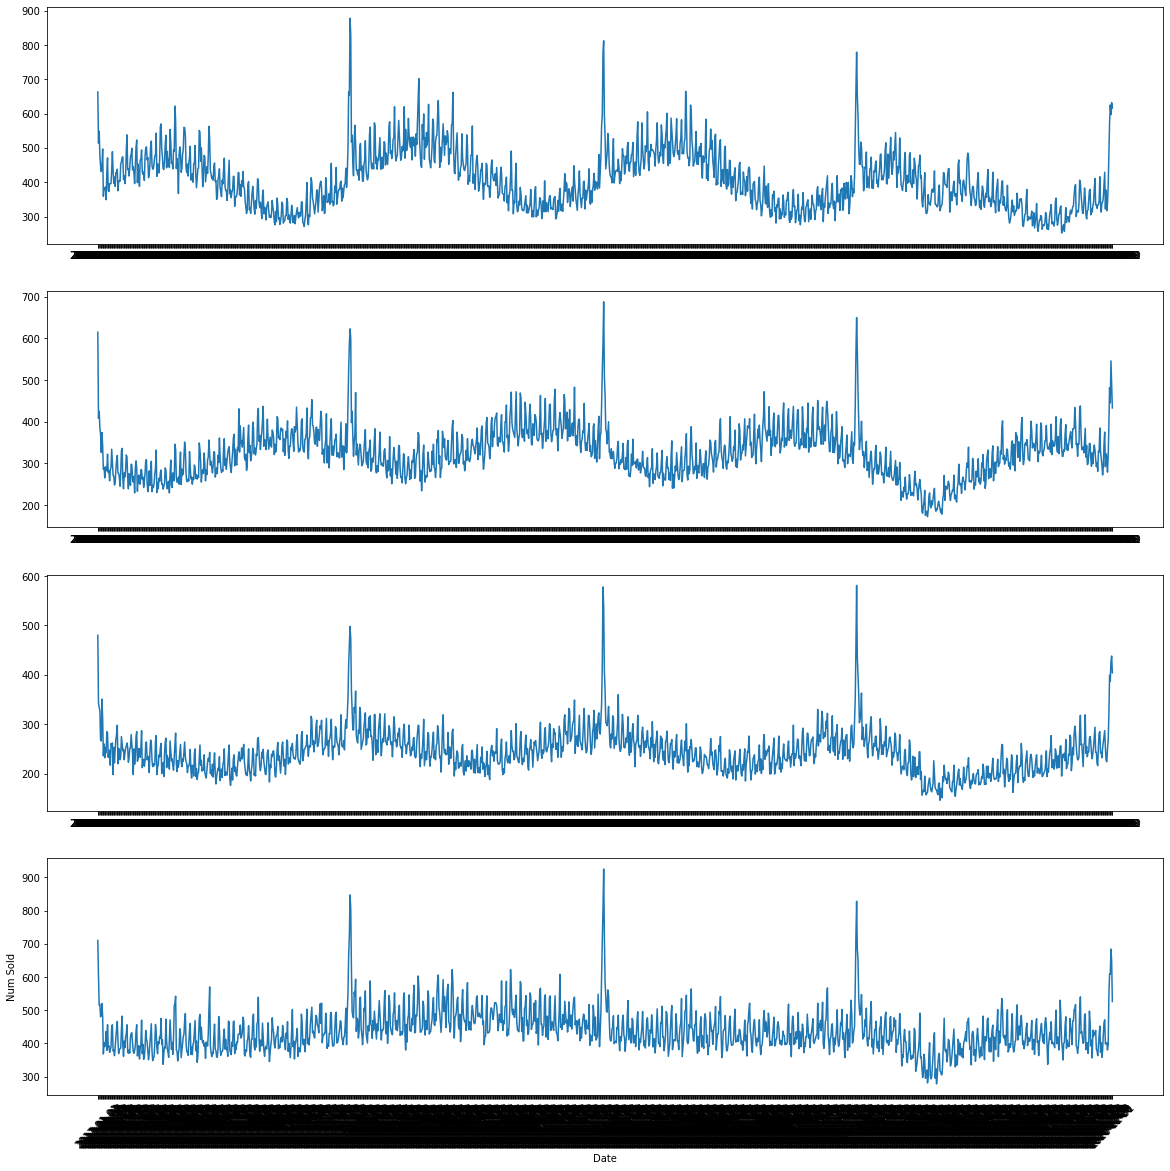

In [9]:
from matplotlib.pyplot import figure, subplot
plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots(4)
for i in range(4):
    ax[i].plot('date', 'num_sold', data=X_train[i], linestyle='solid')
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Num Sold')

We now also can and should think of model validation, especially data, which we will use for it. My idea is to chop off a whole year of a train dataset and check SMAPE on that chunk of data, then we could manipulate the hyperparameters and then let our models learn from another year, and only then predict values for test dataset.

In [8]:
X_train_mini = []
X_eval = []

In [9]:
for i in X_train:
    X_train_mini.append(i[i['date'] <= '2020-01-01'])
    X_eval.append(i[i['date'] > '2020-01-01'])

In [10]:
X_train_mini[0]

,date,num_sold
0,2017-01-01,663
48,2017-01-02,514
96,2017-01-03,549
144,2017-01-04,477
192,2017-01-05,447
...,...,...
52368,2019-12-28,669
52416,2019-12-29,779
52464,2019-12-30,652
52512,2019-12-31,594


**Here let's try using from statsmodels.tsa.seasonal.STL**

In [48]:
temp = X_train[0].copy()

In [57]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

stl = STL(temp, seasonal=51, robust=True)
res = stl.fit()
fig = res.plot()

ValueError: could not convert string to float: '2017-01-01'

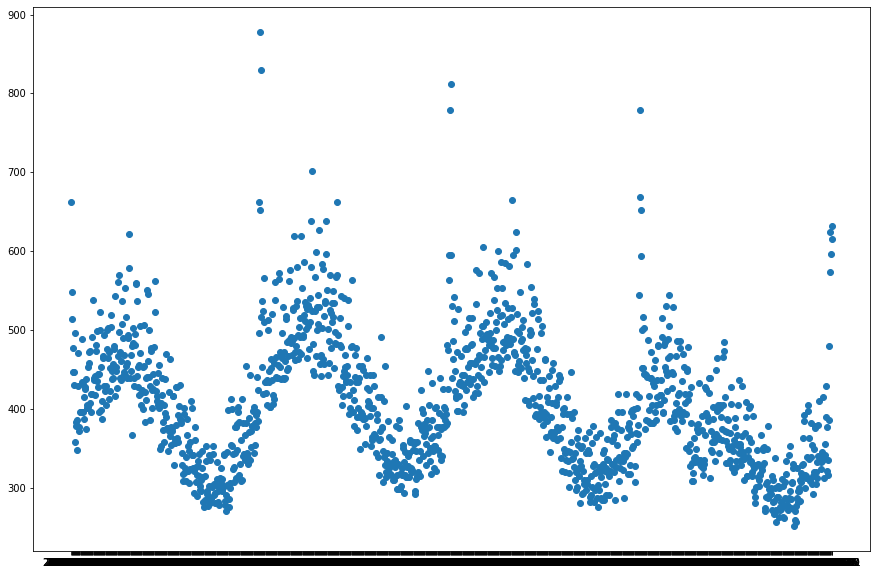

In [19]:
# X_train[0]
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot_date(x=X_train[0]['date'], y=X_train[0]['num_sold'])

Plotting the trend

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
detrended = signal.detrend(X_train[0].num_sold.values)
#plt.plot(X_train[0]['num_sold'] - detrended)
#plt.plot(X_train[0]['num_sold'])

In [58]:
temp

,date,num_sold
0,2017-01-01,663
1,2017-01-02,514
2,2017-01-03,549
3,2017-01-04,477
4,2017-01-05,447
...,...,...
1456,2020-12-27,574
1457,2020-12-28,625
1458,2020-12-29,597
1459,2020-12-30,632


In [13]:
temp = X_train[0].copy()

temp.reset_index(inplace=True)
temp.drop('index', axis=1, inplace=True)
temp.date = temp.date.astype('datetime64[ns]')
temp

,date,num_sold
0,2017-01-01,663
1,2017-01-02,514
2,2017-01-03,549
3,2017-01-04,477
4,2017-01-05,447
...,...,...
1456,2020-12-27,574
1457,2020-12-28,625
1458,2020-12-29,597
1459,2020-12-30,632


In [ ]:
models = [] #gotta be 48 models

**Now we did all the preparations we need, let's dive into modelling**

Here we start with a common practice CalendarFourier and DP. I guess here we could pipelines, but to make things faster I will stick with an ancient and not so pretty way. Hope some day will figure out how to use pipelines here.

In [19]:
X_train[0].tail()

,date,num_sold
69888,2020-12-27,574
69936,2020-12-28,625
69984,2020-12-29,597
70032,2020-12-30,632
70080,2020-12-31,616


In [28]:
date_range_1 = pd.date_range(start='2017-01-01', end='2020-12-31')
date_range_2 = pd.date_range(start='2017-01-01', end='2019-12-31')
date_range_3 = pd.date_range(start='2021-01-01', end='2021-12-31')
date_range_test_for_2 = pd.date_range(start='2020-01-01', end='2020-12-31')

In [14]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
#
# fourier = CalendarFourier(freq='A', order=550)

# dp = DeterministicProcess(
#     index=temp.date,
#     constant=True,               # dummy feature for bias (y-intercept)
#     order=2,                     # trend (order 1 means linear)
#     seasonal=True,               # weekly seasonality (indicators)
#     additional_terms=[fourier],  # annual seasonality (fourier)
#     drop=True,                   # drop terms to avoid collinearity
# )
fourier = CalendarFourier(freq='A', order=550)

dp = DeterministicProcess(
    index=temp.date,
    constant=True,               # dummy feature for bias (y-intercept)
    order=2,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

In [26]:
fourier_d_r_1 = CalendarFourier(freq='A', order=200)
dp_d_r_1 = DeterministicProcess(
    index=date_range_1,
    constant=True,               # dummy feature for bias (y-intercept)
    order=2,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier_d_r_1],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

In [30]:
fourier_d_r_2 = CalendarFourier(freq='A', order=200)
dp_d_r_2 = DeterministicProcess(
    index=date_range_2,
    constant=True,               # dummy feature for bias (y-intercept)
    order=2,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier_d_r_2],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

In [15]:
X = dp.in_sample()

In [27]:
date_range_1_dp_sample = dp_d_r_1.in_sample()

In [31]:
date_range_2_dp_sample = dp_d_r_2.in_sample()

In [ ]:
date_range_2_df_OUT = dp_d_r_2.out_of_sample(steps=365)

In [16]:
temp_model = LinearRegression(fit_intercept=False)
y1 = X_train[0]['num_sold'][:1096]
y2 = X_train[0]['num_sold'][1096:]
X1 = X[:1096]
X2 = X[1096:]

In [17]:
X1_fore = dp.out_of_sample(steps=365)

c:\Users\Serueja\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\Serueja\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:435: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\Serueja\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:691: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit incre

TypeError: CalendarFourier terms can only be computed from DatetimeIndex and PeriodIndex

Next cell is very very important

In [141]:
X

,trend,trend_squared,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(538,freq=A-DEC)","cos(539,freq=A-DEC)","cos(541,freq=A-DEC)","cos(542,freq=A-DEC)","cos(544,freq=A-DEC)","cos(545,freq=A-DEC)","sin(546,freq=A-DEC)","sin(548,freq=A-DEC)","cos(549,freq=A-DEC)","cos(550,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
2017-01-02,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.162807,-0.989314,-0.993747,-0.995521,-0.998186,-0.999074,0.025818,-0.008607,-0.999667,-0.999074
2017-01-03,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,-0.321270,0.957485,0.975065,0.982126,0.992749,0.996298,-0.051620,0.017213,0.998667,0.996298
2017-01-04,4.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.471160,-0.905193,-0.944188,-0.959933,-0.983709,-0.991677,0.077386,-0.025818,-0.997001,-0.991677
2017-01-05,5.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,-0.608477,0.833556,0.901502,0.929141,0.971100,0.985220,-0.103102,0.034422,0.994671,0.985220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1457.0,2122849.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.085731,0.996318,...,-0.810025,-0.653680,-0.773351,-0.824855,-0.909308,-0.941634,-0.254671,-0.085731,-1.000000,-0.996318
2020-12-28,1458.0,2125764.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.068615,0.997643,...,0.685548,0.773351,0.852864,0.886680,0.941634,0.962513,0.204552,0.068615,1.000000,0.997643
2020-12-29,1459.0,2128681.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.051479,0.998674,...,-0.536696,-0.870285,-0.916317,-0.935717,-0.967028,-0.978856,-0.153891,-0.051479,-1.000000,-0.998674


In [161]:
temp_model = LinearRegression(fit_intercept=False)
y1 = X_train[0]['num_sold'][:1096]
y2 = X_train[0]['num_sold'][1096:]
X1 = X[:1096]

X2 = pd.out
_1 = temp_model.fit(X1, y1)

smape(temp_model.predict(X2), y2)

199.9989310791759

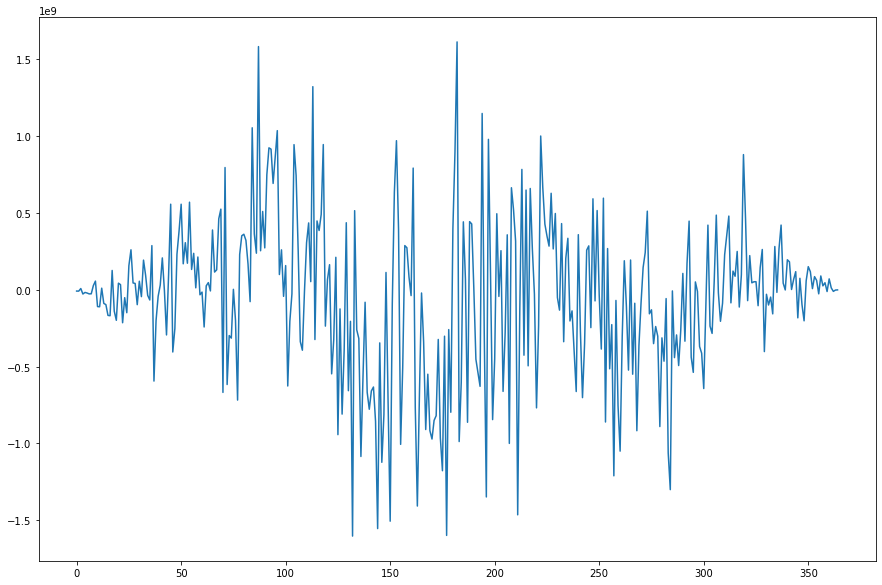

In [172]:
#ax = plt.plot(temp_model.predict(X2))
#ax = plt.plot(y2.reset_index().drop('index', axis=1))

2.9671718443004966

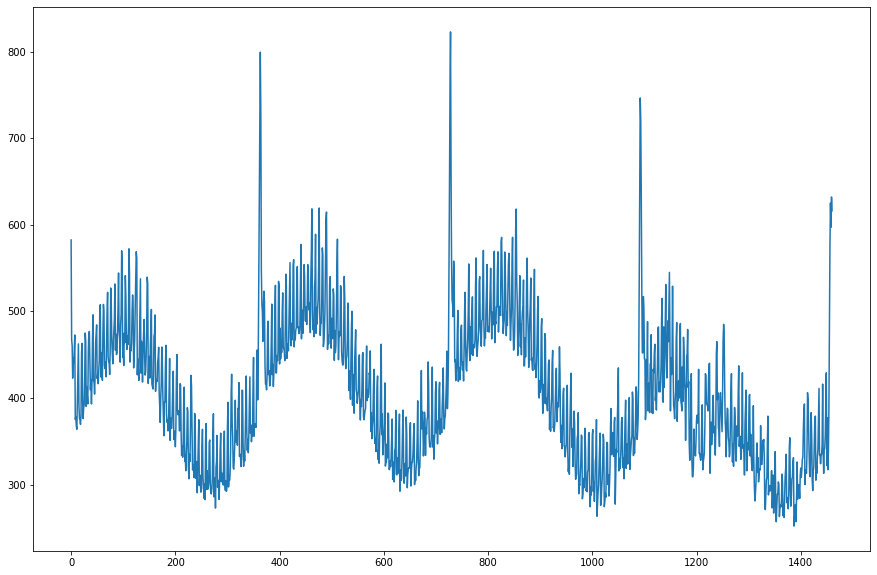

In [140]:
y = X_train[0]['num_sold']
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

ax = plt.plot(model.predict(X))
ax = plt.plot(X_train[0]['num_sold'].values)

smape(model.predict(X), X_train[0]['num_sold'])

In [139]:
model.predict(X)

array([582.38815389, 467.51833317, 460.18272582, ..., 596.9999999 ,
       632.00000012, 615.99999987])

AttributeError: 'numpy.ndarray' object has no attribute 'index'